### Imports

In [4]:
from __future__ import print_function
import numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, utils
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import time
import h5py
from pathlib import Path
import os


from art.classifiers import PyTorchClassifier
from art.utils import load_cifar10
from art.utils import load_dataset


%matplotlib inline
%config InlineBackend.figure_format='retina'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Dataset

In [6]:
# Read CIFAR10 dataset
(x_train, y_train), (x_test, y_test), min_, max_ = load_cifar10()

x_train = np.swapaxes(x_train, 1, 3).astype(np.float32)
x_test = np.swapaxes(x_test, 1, 3).astype(np.float32)

train_dataset = TensorDataset(torch.Tensor(x_train), torch.Tensor(y_train))
train_dataloader = DataLoader(train_dataset, batch_size=128)

test_dataset = TensorDataset(torch.Tensor(x_test), torch.Tensor(y_test))
test_dataloader = DataLoader(test_dataset, batch_size=1000)
test_dataloader_single = DataLoader(test_dataset, batch_size=1)

In [23]:
class_to_idx = {'airplane': 0,
                 'automobile': 1,
                 'bird': 2,
                 'cat': 3,
                 'deer': 4,
                 'dog': 5,
                 'frog': 6,
                 'horse': 7,
                 'ship': 8,
                 'truck': 9}

idx_to_class = dict([(value, key) for key, value in class_to_idx.items()]) 

### Inputs

In [7]:
epsilons = [0, .05, .1, .15, .2, .25, .3]
path = Path("C:/Users/Matach/Documents/Imperial College London/FYP/saved_models/CIFAR10/FGSM/vanilla/model_03.pth")
pretrained_model = path
use_cuda = True

## Model

In [8]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()

        self.conv_layer = nn.Sequential(

            # Conv Layer block 1
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Conv Layer block 2
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(p=0.05),

            # Conv Layer block 3
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        
        self.dropout = nn.Dropout(p=0.1)
        self.fc1 = nn.Linear(4096, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 10)
        
    activations = []             # list to save the activations of the penultimate layer while training on forwardDetect
    mask = torch.zeros(1, 4096)   # mask for the forwardMask function for pruning
    

    def forward(self, x):
        x = self.conv_layer(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x
    
    def forwardDetect(self, x):
        x = self.conv_layer(x)
        x = x.view(x.size(0), -1)
        self.activations.append(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
    def forwardMask(self, x):
        x = self.conv_layer(x)
        x = x.view(x.size(0), -1)*self.mask
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    
# Initialize the model.
model = Model().to(device)

# Load pre-trained model
model.load_state_dict(torch.load(pretrained_model, map_location='cpu'))

# Set the model in evaluation mode. In this case this is for the Dropout layers
print(model.eval())

# Load loss and optimiser
criterion = nn.CrossEntropyLoss()
decay = 0
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=decay)

Model(
  (conv_layer): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Dropout2d(p=0.05, inplace=False)
    (11): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (dropout): Dropout(p=0.1, inplace=F

In [9]:
def test_model(cl,test_loader): 
    correct = 0
    with torch.no_grad():
        cl.eval()
        for data, target in test_loader:
            output = cl(data.to(device))
            pred = output.data.max(1, keepdim=True)[1].to("cpu")
            target = np.argmax(target, axis=1)
            correct += pred.eq(target.data.view_as(pred)).sum()
        acc_test = float(correct.numpy() / len(test_loader.dataset))
        
    return acc_test

test_model(model, test_dataloader)

0.7961

### FGSM attack

In [10]:
# FGSM attack code
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image

### Run attack
Check lines 17-18 and 36-37 to see what model are we running

In [11]:
def test( model, device, test_loader, epsilon ):

    # Accuracy counter
    correct = 0
    adv_examples = []

    # Loop over all examples in test set
    for data, target in test_loader:

        # Send the data and label to the device
        data, target = data.to(device), target.to(device)

        # Set requires_grad attribute of tensor. Important for Attack
        data.requires_grad = True

        # Forward pass the data through the model
#         output = model(data)
        output = model.forwardMask(data)
        init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        target = torch.argmax(target, axis=1) # required for matching shapes

        # If the initial prediction is wrong, dont bother attacking, just move on
        if init_pred.item() != target.item():
            continue

        # Calculate the loss
        loss = F.nll_loss(output, target)
        # Zero all existing gradients
        model.zero_grad()
        # Calculate gradients of model in backward pass
        loss.backward()
        # Collect datagrad
        data_grad = data.grad.data
        # Call FGSM Attack
        perturbed_data = fgsm_attack(data, epsilon, data_grad)
        # Re-classify the perturbed image
        output = model.forwardMask(perturbed_data)
#         output = model(perturbed_data)

        # Check for success
        final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        if final_pred.item() == target.item():
            correct += 1
            # Special case for saving 0 epsilon examples
            if (epsilon == 0) and (len(adv_examples) < 5):
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        else:
            # Save some adv examples for visualization later
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )

    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(test_loader))
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))

    # Return the accuracy and an adversarial example
    return final_acc, adv_examples

In [45]:
accuracies = []
examples = []

# Run test for each epsilon
for eps in epsilons:
    acc, ex = test(model, device, test_dataloader_single, eps)
    accuracies.append(acc)
    examples.append(ex)

Epsilon: 0	Test Accuracy = 7943 / 10000 = 0.7943
Epsilon: 0.05	Test Accuracy = 4057 / 10000 = 0.4057
Epsilon: 0.1	Test Accuracy = 2989 / 10000 = 0.2989
Epsilon: 0.15	Test Accuracy = 2189 / 10000 = 0.2189
Epsilon: 0.2	Test Accuracy = 1703 / 10000 = 0.1703
Epsilon: 0.25	Test Accuracy = 1410 / 10000 = 0.141
Epsilon: 0.3	Test Accuracy = 1261 / 10000 = 0.1261


## Pruning Conv

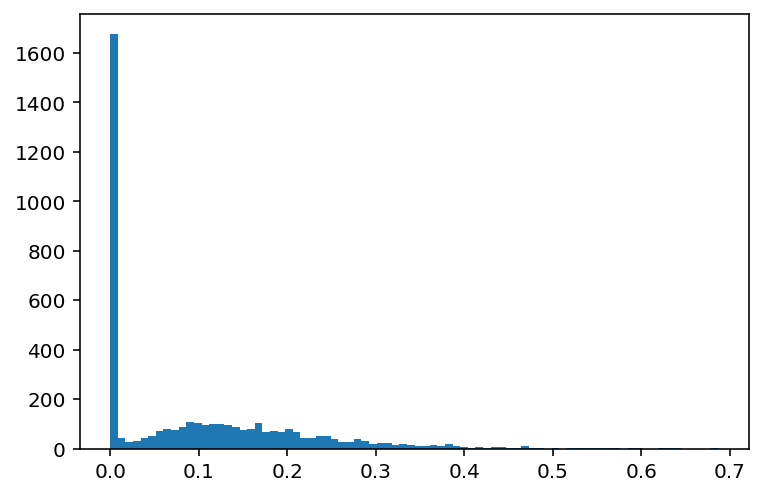

In [19]:
### Get activations in the layer previous to the output layer ###

model.eval() 
with torch.no_grad():
    for data, target in test_dataloader:
        output = model.forwardDetect(data.to(device))
activations = model.activations
n = len(activations)
element0 = activations.pop()
act = torch.zeros(n,element0.size(0),element0.size(1))
act[0,:,:] = element0

for e in range(n-1):
    elementX = activations.pop()
    act[e+1,:,:] = elementX

mean_activations = torch.mean(act,dim=[0,1])
ma = mean_activations.numpy()
plt.hist(ma,80)
plt.show()

In [13]:
# save different masks for different percentages

acc = []
masks = dict()

for percentage in range(10):
    s_ma, idx_ma = torch.sort(mean_activations)
    m = torch.ones(mean_activations.size()).to(device)
    nn = mean_activations.size(0)
    
    ind_r = round((percentage/10)*nn)
    m[idx_ma[:ind_r]] = 0.0
    n1 = m.sum()
    model.mask = m
    masks[percentage/10] = model.mask

In [14]:
# evaluate with the new masks

for pg, mask in masks.items():
    model.mask = mask
    model.eval()
    correct = 0
    with torch.no_grad():
        for data, target in test_dataloader:
            output = model.forwardMask(data.to(device))
            pred = output.data.max(1, keepdim=True)[1].to("cpu")
            target = np.argmax(target, axis=1)
            correct += pred.eq(target.data.view_as(pred)).sum()
        acc_test = float(correct.numpy() / len(test_dataloader.dataset))
        acc.append(acc_test)

    print("Pruned {}  Accuracy: {} %".format(pg, 100*acc_test))

Pruned 0.0  Accuracy: 79.61 %
Pruned 0.1  Accuracy: 79.61 %
Pruned 0.2  Accuracy: 79.61 %
Pruned 0.3  Accuracy: 79.61 %
Pruned 0.4  Accuracy: 79.61 %
Pruned 0.5  Accuracy: 79.12 %
Pruned 0.6  Accuracy: 78.3 %
Pruned 0.7  Accuracy: 76.83 %
Pruned 0.8  Accuracy: 74.21 %
Pruned 0.9  Accuracy: 65.59 %


In [20]:
# FGSM ATTACK
fgsm_prune = dict()

# Run test for each epsilon and mask PG 
for pg, mask in masks.items():
    print('\n Pruned {}'.format(pg))
    accuracies = []
    examples = []
    results = dict()
    
    model.mask = mask
    for eps in epsilons:
        acc, ex = test(model, device, test_dataloader_single, eps)
        accuracies.append(acc)
        examples.append(ex)
    results['accuracies'] = accuracies
    results['examples'] = examples
    results['epsilons'] = epsilons
    fgsm_prune[pg] = results


 Pruned 0.0
Epsilon: 0	Test Accuracy = 7961 / 10000 = 0.7961
Epsilon: 0.05	Test Accuracy = 3956 / 10000 = 0.3956
Epsilon: 0.1	Test Accuracy = 3276 / 10000 = 0.3276
Epsilon: 0.15	Test Accuracy = 2726 / 10000 = 0.2726
Epsilon: 0.2	Test Accuracy = 2341 / 10000 = 0.2341
Epsilon: 0.25	Test Accuracy = 2065 / 10000 = 0.2065
Epsilon: 0.3	Test Accuracy = 1830 / 10000 = 0.183

 Pruned 0.1
Epsilon: 0	Test Accuracy = 7961 / 10000 = 0.7961
Epsilon: 0.05	Test Accuracy = 3956 / 10000 = 0.3956
Epsilon: 0.1	Test Accuracy = 3276 / 10000 = 0.3276
Epsilon: 0.15	Test Accuracy = 2726 / 10000 = 0.2726
Epsilon: 0.2	Test Accuracy = 2341 / 10000 = 0.2341
Epsilon: 0.25	Test Accuracy = 2065 / 10000 = 0.2065
Epsilon: 0.3	Test Accuracy = 1830 / 10000 = 0.183

 Pruned 0.2
Epsilon: 0	Test Accuracy = 7961 / 10000 = 0.7961
Epsilon: 0.05	Test Accuracy = 3956 / 10000 = 0.3956
Epsilon: 0.1	Test Accuracy = 3276 / 10000 = 0.3276
Epsilon: 0.15	Test Accuracy = 2726 / 10000 = 0.2726
Epsilon: 0.2	Test Accuracy = 2342 / 10000 =

## Results

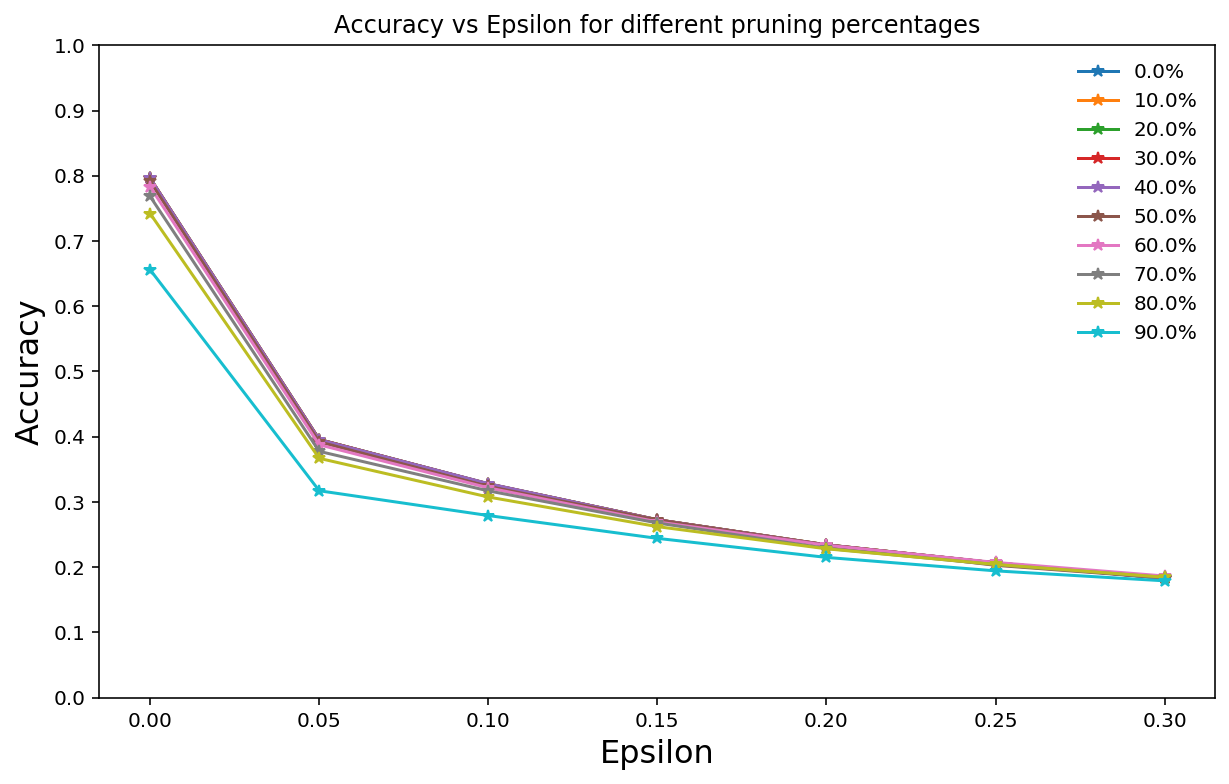

In [21]:
# plot the pruned accuracies vs epsilon

plt.figure(figsize=(10,6))

for pg, results in fgsm_prune.items():
    plt.plot(epsilons, results['accuracies'], "*-", label=str(pg*100)+"%")

plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Accuracy vs Epsilon for different pruning percentages")
plt.xlabel("Epsilon",fontsize=16)
plt.ylabel("Accuracy",fontsize=16)
plt.legend(loc='upper right', frameon=False)
plt.show()

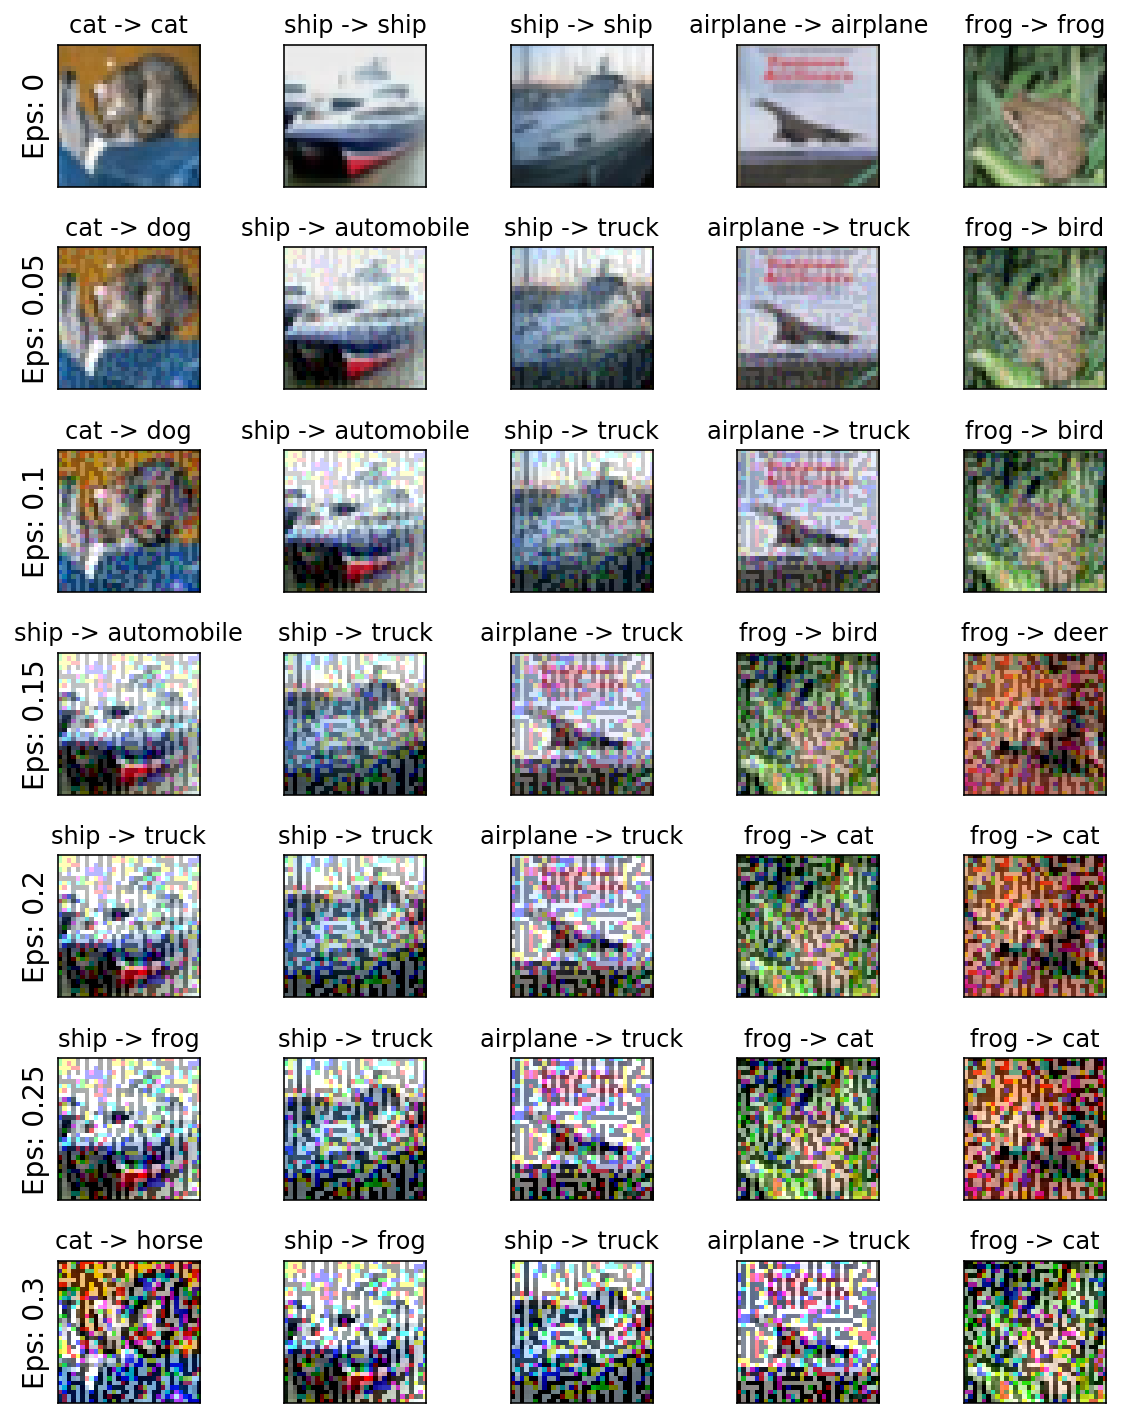

In [29]:
# Plot several examples of adversarial samples at each epsilon
examples = fgsm_prune[0.1]['examples']
cnt = 0
plt.figure(figsize=(8,10))
for i in range(len(epsilons)):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(examples[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
        orig,adv,ex = examples[i][j]
        orig, adv = idx_to_class[orig], idx_to_class[adv]
        plt.title("{} -> {}".format(orig, adv))
        ex = np.swapaxes(ex, 0, 2).astype(np.float32)
        plt.imshow(ex)
plt.tight_layout()
plt.show()